# Introducción, objetivos y contenido

Este trabajo corresponde a la fase de EDA (Exploratory data analysis). El objetivo de esta fase es obtener una comprensión del contenido de los datasets limpios, así como investigar las relaciones entre variables.

Contenidos:
* Importación de librerías
* Carga de datos y creación de datasets para EDA
* (Preprocesamiento de datos ya realizado en la fase de ETL)
* Análisis de mercado
    * Géneros más vendidos
    * Juegos más vendidos
    * Desarrolladores más exitosos
    * Playtime histórico
    * Análisis de precios
    * Análisis de ventas
    * Análisis de usuario (preferencias del usuario genérico)
* Correlaciones entre variables
    * Armado de dataframe
        * Plan de armado
        * Unión de dataframes
        * Limpieza
    * Análisis de distribuciones
    * Correlaciones entre variables
* Definición de dataframe para MLO

# Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import factorial
from scipy import stats as st
import json
import gzip
import ast
from pandas import json_normalize
from textblob import TextBlob
import re

# Carga de datos y creación de datasets para EDA

IMPORTANTE: El preprocesamiento de datos (evaluación de tipos de datos, verificación de nulos, duplicados, etc) se encuentra asentado en el archivo ETL.

In [2]:
df_games = pd.read_csv('df_games.csv')
df_reviews = pd.read_csv('df_reviews.csv')
df_usage = pd.read_csv('df_usage.csv')

In [3]:
df_games.sample(2)

,item_id,app_name,genres,year,price,developer
10537,752010,Rogue Zillion,Action,2017,4.99,Manic Mind Game Lab
9363,662990,Eddy紫 ~Eddy Violet~,Action,2017,2.99,大谷 DGSpitzer


In [4]:
df_reviews.sample(2)

,item_id,user_id,recommend,year_review,polarity,sentiment
43947,252950.0,ZePudding,True,0,-0.033333,0
20324,322170.0,0136849195,True,0,0.102778,2


In [5]:
df_usage.sample(2)

,item_id,user_id,playtime_forever
3377698,203160.0,76561198048494523,554.0
4218600,15100.0,JAJAY797,187.0


In [6]:
# Creación de dataset para EDA
df_usagebyitem = df_usage.groupby('item_id')['playtime_forever'].sum().reset_index()
df_eda = pd.merge(df_usagebyitem, df_games, on="item_id", how="inner")
df_eda.sample(2)

,item_id,playtime_forever,app_name,genres,year,price,developer
1545,222140.0,44206.0,Puddle,Action,2012,7.99,Neko Entertainment
4261,342020.0,16096.0,BiT Evolution,Action,2015,9.99,Major Games


In [7]:
# Creación de dataset de VENTAS anuales por item
df_sales_year = df_reviews.groupby(['item_id', 'year_review'])['user_id'].count().reset_index()
# Cambiar nombres de columnas
df_sales_year = df_sales_year.rename(columns={'year_review': 'year', 'user_id': 'units_sold'})

# Mostrar el DataFrame con los nombres de columnas actualizados
df_sales_year = pd.merge(df_sales_year, df_games[['item_id','price']], on='item_id', how='inner')
df_sales_year['sales'] = df_sales_year['units_sold'] * df_sales_year['price']
df_sales_year = df_sales_year[df_sales_year['year'] != 0]
df_sales_year = df_sales_year.dropna(subset=['price'])
df_sales_year. sample(2)

,item_id,year,units_sold,price,sales
2061,216110.0,2015,3,4.99,14.97
1431,73220.0,2014,1,9.99,9.99


In [8]:
# Creación de dataset de VENTAS HISTORICAS por item
df_sales_hist = df_sales_year.groupby(['item_id'])['sales'].sum().reset_index()
df_sales_hist = df_sales_hist.rename(columns={'sales': 'sales_hist'})
df_sales_hist.sample(2)

,item_id,sales_hist
547,105700.0,0.99
72,4760.0,169.83


# Análisis de mercado

En esta sección veremos un análisis general de los principales indicadores a analizar en un EDA, teniendo en cuenta el tipo de mercado, el tipo de producto que se vende, y el tipo de consumo por parte del usuario.

## Análisis de géneros más vendidos

In [9]:
# Tabla con el top ten de géneros vendidos
genres_topten = df_eda.groupby('genres')['playtime_forever'].sum().reset_index().sort_values(by='playtime_forever', ascending=False).head(10)
genres_topten

,genres,playtime_forever
0,Action,2.573898e+09
9,Indie,5.512920e+08
17,Strategy,2.386307e+08
12,RPG,1.125901e+08
1,Adventure,7.288800e+07
14,Simulation,6.054775e+07
4,Casual,3.050372e+07
13,Racing,1.370957e+07
10,Massively Multiplayer,1.311834e+07
16,Sports,4.159498e+06


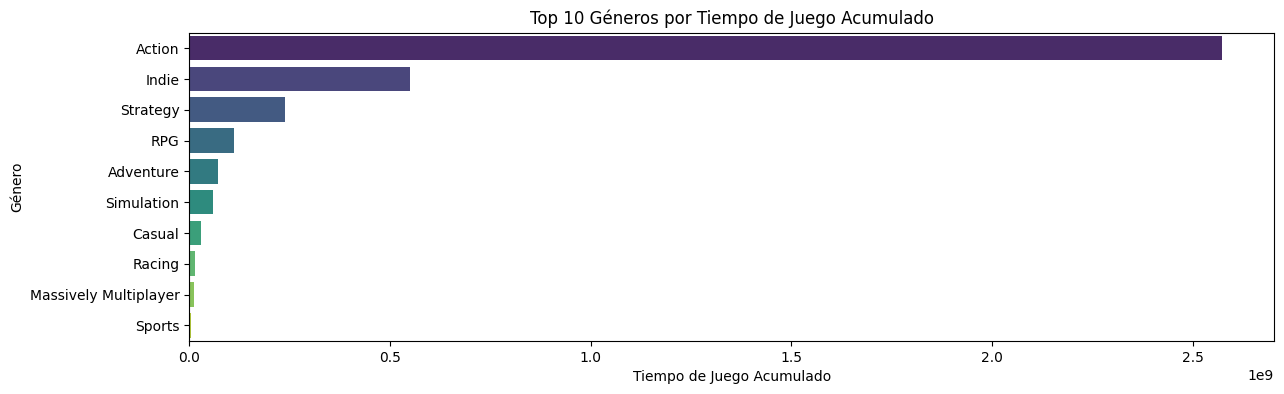

In [10]:
# Graficando
plt.figure(figsize=(14, 4))
sns.barplot(x='playtime_forever', y='genres', data=genres_topten, hue='genres', palette='viridis')
#plt.xscale('log')
plt.xlabel('Tiempo de Juego Acumulado')
plt.ylabel('Género')
plt.title('Top 10 Géneros por Tiempo de Juego Acumulado')
plt.show()

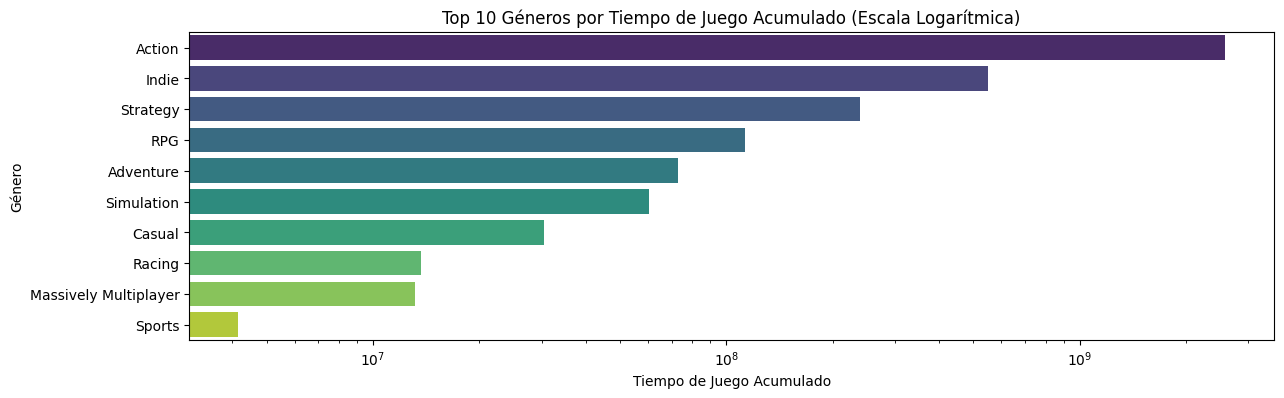

In [11]:
# Gráfico en escala logarítmica para mejorar su visualización
plt.figure(figsize=(14, 4))
sns.barplot(x='playtime_forever', y='genres', data=genres_topten, hue='genres', palette='viridis')
plt.xscale('log')
plt.xlabel('Tiempo de Juego Acumulado')
plt.ylabel('Género')
plt.title('Top 10 Géneros por Tiempo de Juego Acumulado (Escala Logarítmica)')
plt.show()
plt.show()

El gráfico de barras horizontales muestra los primeros 10 géneros más vendidos. Claramente el género ACTION es el más elegido. En segundo y tercer lugar, los géneros INDIE y STRATEGY quedan muy por detrás. Veamos un poco más de detalle de estas interacciones con un gráfico de Pareto.

In [12]:
genres_pareto = df_eda.groupby('genres')['playtime_forever'].sum()
genres_pareto = genres_pareto.sort_values(ascending=False).reset_index()
genres_pareto['cumulative_percentage'] = (genres_pareto['playtime_forever'].cumsum() /  genres_pareto['playtime_forever'].sum()) * 100

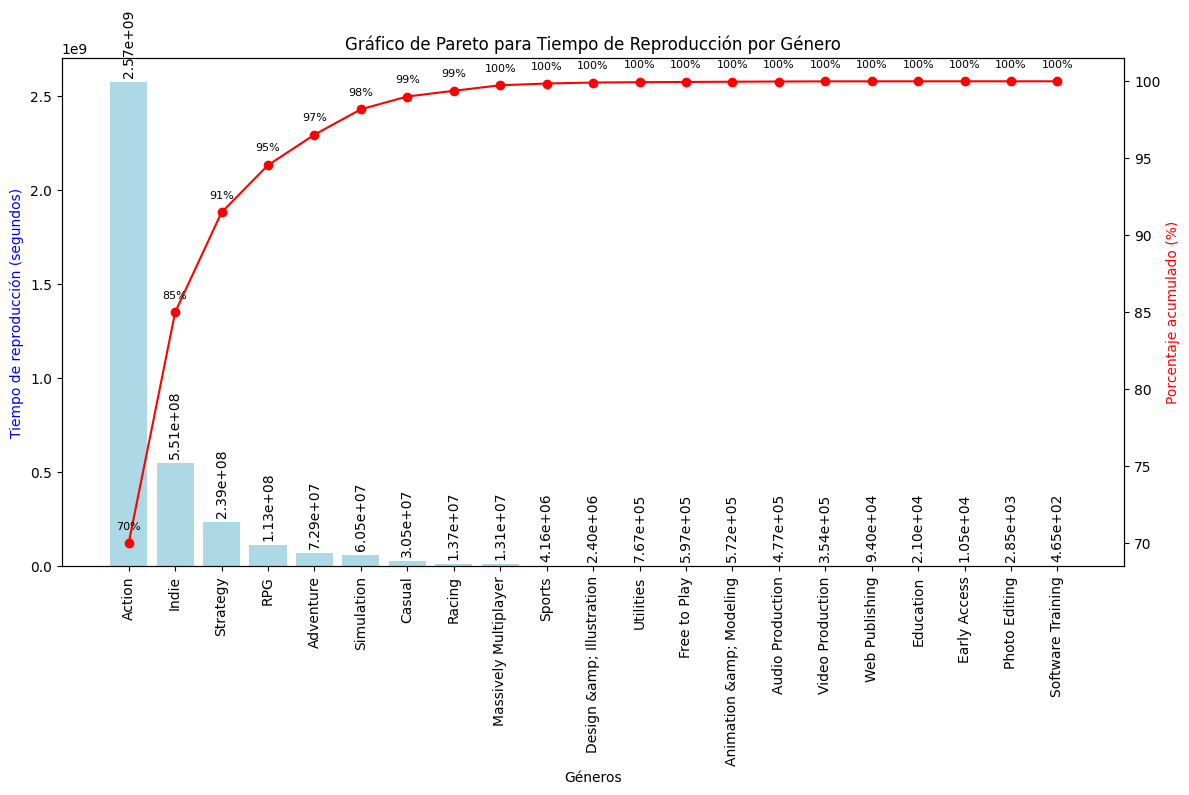

In [13]:
# Gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(12, 8))

# Barras verticales para el tiempo de reproducción
bars = ax1.bar(genres_pareto['genres'], genres_pareto['playtime_forever'], color='lightblue')
ax1.set_xlabel('Géneros')
ax1.set_ylabel('Tiempo de reproducción (segundos)', color='b')

for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2e}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords='offset points',
                 ha='center', va='bottom', rotation=90)  # Rotación de 90 grados

ax2 = ax1.twinx() # Crear el segundo eje y para el porcentaje acumulado
ax2.plot(genres_pareto['genres'], genres_pareto['cumulative_percentage'], color='r', marker='o', linestyle='-')
ax2.set_ylabel('Porcentaje acumulado (%)', color='r')


for i, value in enumerate(genres_pareto['cumulative_percentage']):      # valores del porcentaje acumulado en el gráfico
    ax2.annotate(f'{value:.0f}%', (i, value), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax1.set_xticks(range(len(genres_pareto['genres'])))
ax1.set_xticklabels(genres_pareto['genres'], rotation=90)

plt.tight_layout()
plt.title('Gráfico de Pareto para Tiempo de Reproducción por Género')
plt.show()


La observación es que los tres primeros géneros abarcan el 90% del mercado. Claramente si un desarrollador tiene interés en invertir en nuevos juegos, los géneros Action, Indie y Strategy son inversiones seguras.

## Análisis de juegos más vendidos

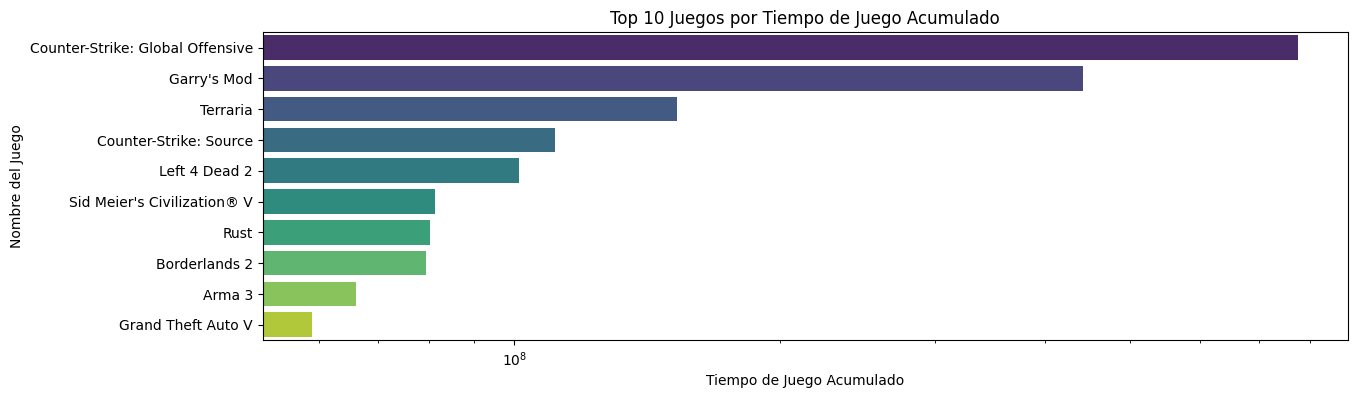

In [14]:
appname_topten = df_eda.groupby('app_name')['playtime_forever'].sum().reset_index().sort_values(by='playtime_forever', ascending=False).head(10)

plt.figure(figsize=(14, 4))
sns.barplot(x='playtime_forever', y='app_name', data=appname_topten, hue='app_name', palette='viridis')
plt.xscale('log')
plt.xlabel('Tiempo de Juego Acumulado')
plt.ylabel('Nombre del Juego')
plt.title('Top 10 Juegos por Tiempo de Juego Acumulado')
plt.show()

## Análisis de desarrolladores más exitosos

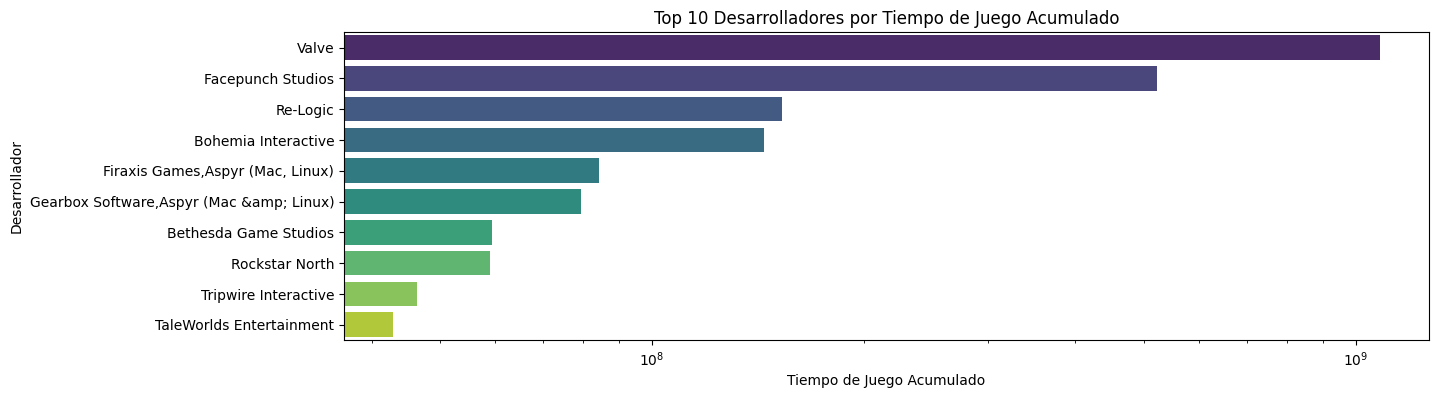

In [15]:
developer_topten = df_eda.groupby('developer')['playtime_forever'].sum().reset_index().sort_values(by='playtime_forever', ascending=False).head(10)

plt.figure(figsize=(14, 4))
sns.barplot(x='playtime_forever', y='developer', data=developer_topten, hue='developer', palette='viridis')
plt.xscale('log')
plt.xlabel('Tiempo de Juego Acumulado')
plt.ylabel('Desarrollador')
plt.title('Top 10 Desarrolladores por Tiempo de Juego Acumulado')
plt.show()

## Análisis de playtime histórico

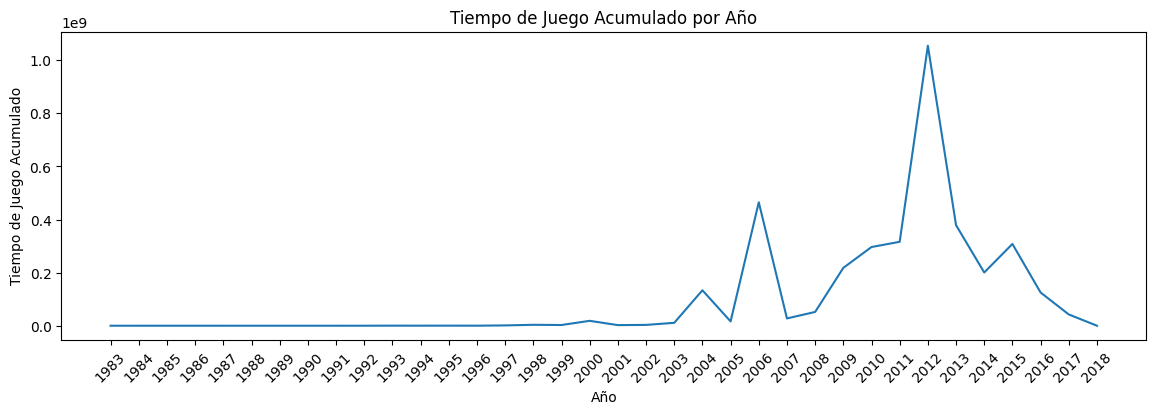

In [16]:
all_years = list(range(df_eda['year'].min(), df_eda['year'].max() + 1))

plt.figure(figsize=(14, 4))
sns.lineplot(x='year', y='playtime_forever', data=df_eda, estimator=sum, errorbar=None)

plt.xlabel('Año')
plt.ylabel('Tiempo de Juego Acumulado')
plt.title('Tiempo de Juego Acumulado por Año')

plt.xticks(all_years, rotation=45)
plt.show()

El mercado de videojuegos registra valores de tiempo de juego acumulado desde la década del '80, sin embargo el crecimiento exponencial se dio a partir de la década de los 2000 con la popularización de plataformas como PlayStation, Xbox y la computadora personal.

Notemos que hay dos picos en los años 2006 y 2012, entre los cuales se observa una caída y luego otro crecimiento exponencial, probablemente debido a la llegada de nuevas consolas como la PS3 y Xbox 360 en 2006, y la PS4 y Xbox One en 2012.

A partir de 2012 el tiempo de juego promedio denota un decrecimiento, el cual se debe a la fragmentación del mercado hacia dispositivos móviles y la computadora personal, aunque esta última sigue siendo la plataforma con mayor tiempo de juego acumulado.

## Análisis de precios

In [17]:
df_eda['price'].describe()

count    7920.000000
mean       10.456028
std        13.370223
min         0.490000
25%         4.990000
50%         8.990000
75%        12.990000
max       771.710000
Name: price, dtype: float64

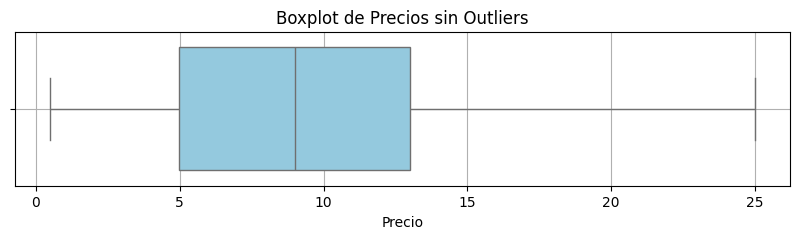

In [18]:
plt.figure(figsize=(10,2))
sns.boxplot(x='price', data=df_eda, color='skyblue', showfliers=False)

plt.xlabel('Precio')
plt.title('Boxplot de Precios sin Outliers')
plt.grid(True)
plt.show()


Si bien el precio promedio es de 10.44, observemos que la mediana es de 7.99. Esto se debe a que hay algunos precios muy altos (outliers) que aumentan el promedio, mientras que la mediana no se ve afectada por los valores extremos. Esto muestra que la mediana puede ser una mejor medida de tendencia central cuando hay valores atípicos.

Veamos un histograma para reconocer la distribución de precios, limitando para precios menores a 25. Claramente se observa que la mayor parte del mercado ofrece juegos a precios menores a un valor de 10.

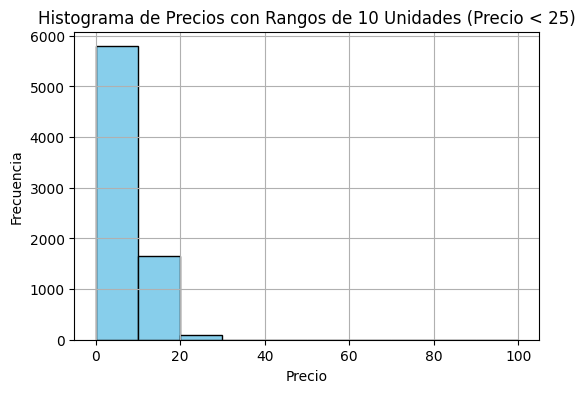

In [19]:
precios_filtrados = df_eda[df_eda['price'] < 100]['price']

rango_precios = np.arange(0, precios_filtrados.max() + 10, 10)

plt.figure(figsize=(6, 4))
plt.hist(df_eda[df_eda['price'] < 25]['price'], bins=rango_precios, color='skyblue', edgecolor='black')

plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios con Rangos de 10 Unidades (Precio < 25)')

plt.grid(True)
plt.show()


## Análisis de ventas

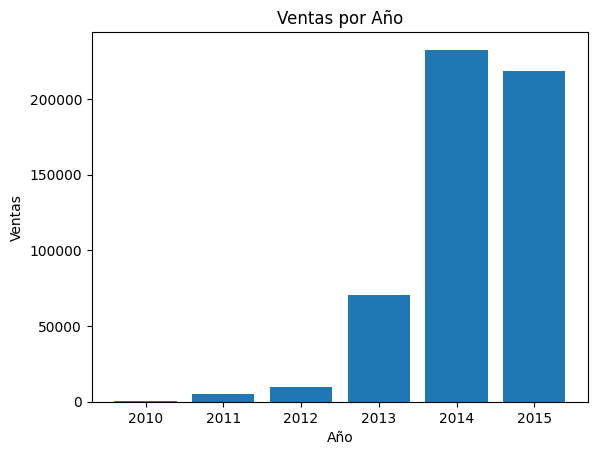

In [20]:
import matplotlib.pyplot as plt

# Agrupar los datos por 'year' y calcular la suma de 'sales' para cada año
df_sales_year_sum = df_sales_year.groupby('year')['sales'].sum()

# Crear el gráfico de barras
plt.bar(df_sales_year_sum.index, df_sales_year_sum.values)

plt.xlabel('Año')
plt.ylabel('Ventas')
plt.title('Ventas por Año')
plt.show()

Los valores de ventas son sinérgicos con los valores de playtime, lo cual es esperable. En este caso, el volumen de ventas brinda a un posible inversor una  idea más tangible del negocio.

## Análisis de usuario

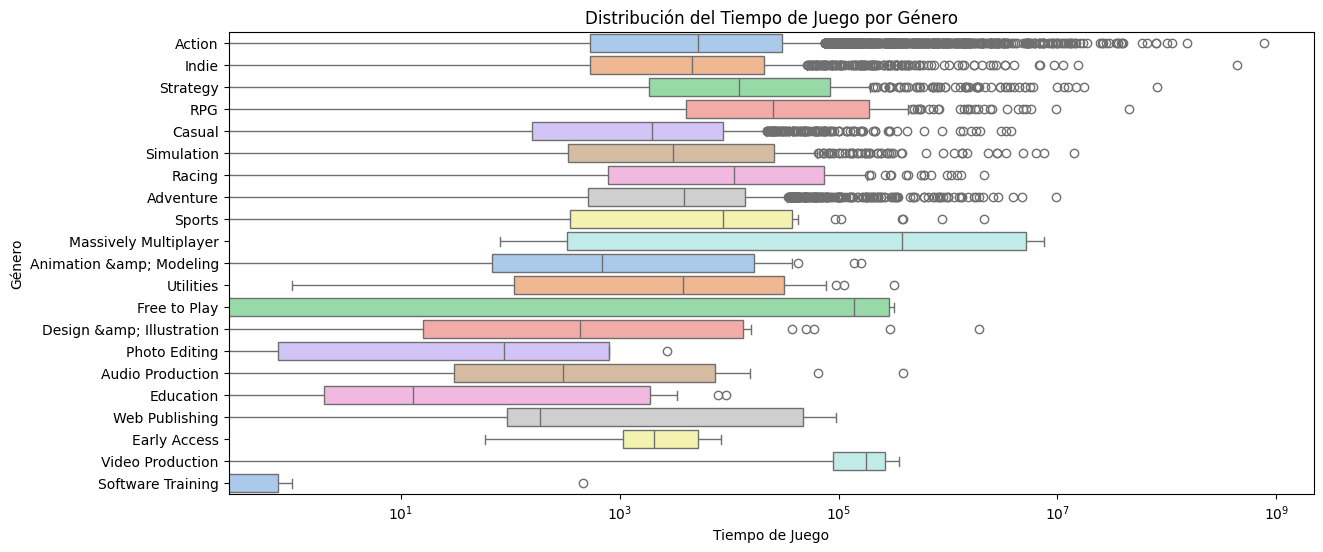

In [21]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='playtime_forever', y='genres', data=df_eda, orient='h',  hue='genres', palette='pastel')

plt.xscale('log')
plt.xlabel('Tiempo de Juego')
plt.ylabel('Género')
plt.title('Distribución del Tiempo de Juego por Género')
plt.show()


Lo interesante de este gráfico es que el género de SOFTWARE TRAINING es muy poco jugado. Evidentemente, el usuario prefiere utilizar su tiempo de jugo para jugar y no para aprender. En caso de que un desarrollador tenga la intención de invertir en juegos para aprendizaje de software, deberá revisar su estrategia.

Vemos que nuevamente los géneros más jugados son ACCIÓN y DEPORTE, lo cual es comprensible considerando que los juegos buscan entretener antes que educar. Un juego que logre combinar entretenimiento con aprendizaje tendría mayores posibilidades de éxito.

Veamos a continuación la evolución de preferencias del usuario en cuanto a géneros, contando a partir del año 2000.

In [22]:
genre_histevol = df_eda[df_eda['year'] > 2000].pivot_table(index='genres', 
                                                        columns='year', 
                                                        values='playtime_forever', 
                                                        aggfunc='sum'
                                                        ).fillna(0)
genre_histevol.head()

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
genres,,,,,,,,,,,,,,,,,,
Action,1321345.0,724698.0,6197155.0,129693956.0,11847919.0,8211324.0,17415832.0,33381499.0,163052577.0,179093269.0,290984098.0,985074852.0,278684470.0,135448422.0,190315407.0,78112462.0,40193947.0,2224.0
Adventure,27387.0,136608.0,2901600.0,56243.0,27263.0,48954.0,53387.0,327720.0,1174469.0,543402.0,4481795.0,15190628.0,9891966.0,13845814.0,9657213.0,12568507.0,1237164.0,0.0
Animation &amp; Modeling,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17914.0,168760.0,76717.0,196947.0,111438.0,0.0,0.0
Audio Production,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15584.0,455463.0,5060.0,459.0,0.0,0.0
Casual,675.0,3632.0,1447.0,13190.0,39328.0,230933.0,576733.0,306798.0,579867.0,2735470.0,1251866.0,892808.0,8083517.0,6464454.0,1661905.0,7599044.0,15353.0,0.0


La tabla dinámica queda algo difícil de visualizar, probemos con otro formato de líneas en función del tiempo.

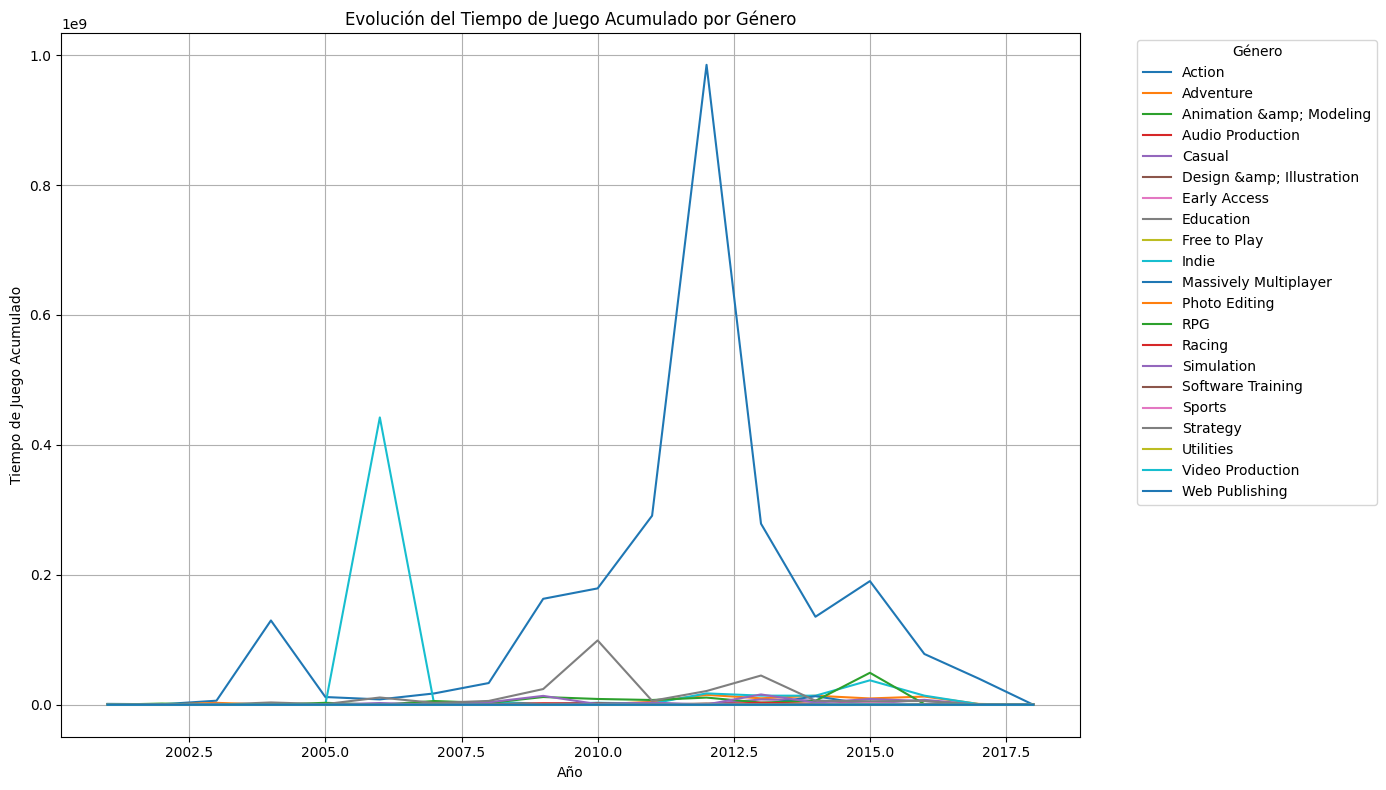

In [23]:
plt.figure(figsize=(14, 8))
for genre in genre_histevol.index:
    plt.plot(genre_histevol.columns, genre_histevol.loc[genre], label=genre)

plt.xlabel('Año')
plt.ylabel('Tiempo de Juego Acumulado')
plt.title('Evolución del Tiempo de Juego Acumulado por Género')

plt.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Si bien es información real, aún falta mejorar su visualización. Probemos con un mapa de calor.

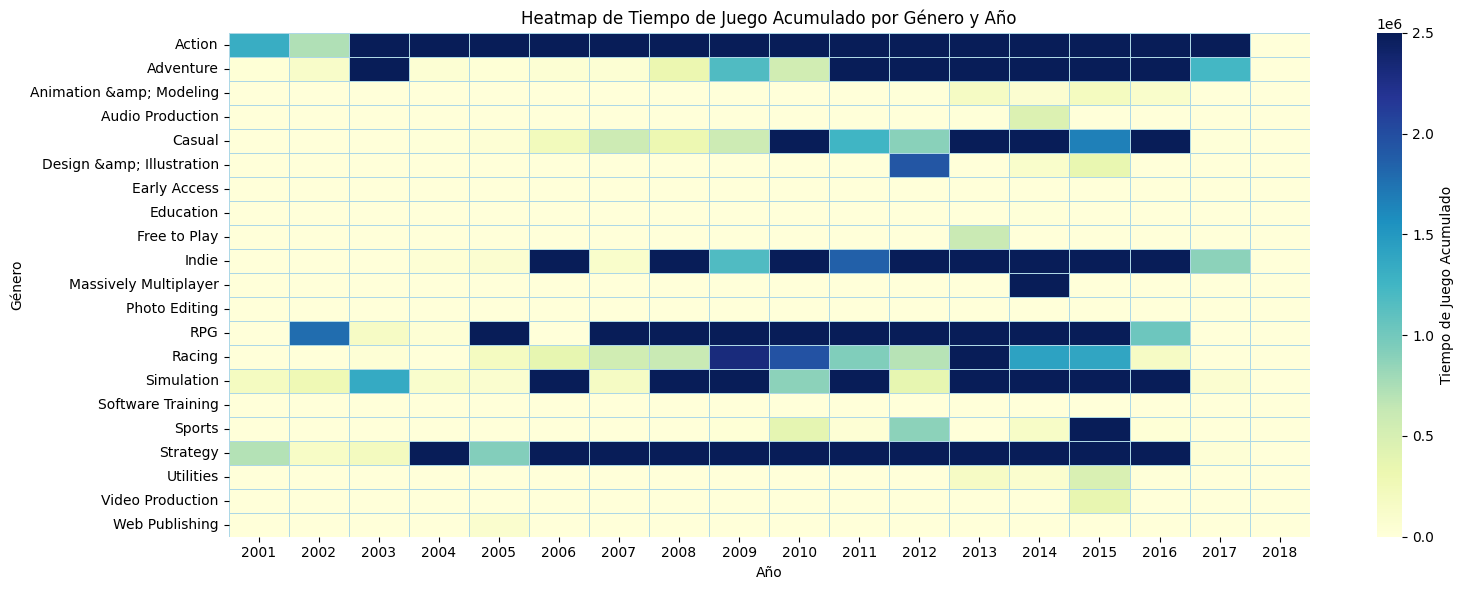

In [24]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(genre_histevol, cmap="YlGnBu", linecolor='lightblue', linewidths=0.5, ax=ax, vmin=0, vmax=2500000)
plt.xlabel('Año')
plt.ylabel('Género')
plt.title('Heatmap de Tiempo de Juego Acumulado por Género y Año')

cbar = ax.collections[0].colorbar
cbar.set_label('Tiempo de Juego Acumulado')

plt.tight_layout()
plt.show()

El mapa de calor nos muestra que el género ACTION ha sido siempre la mayor preferencia del usuario. Los géneros que le siguen, INDIE y STRATEGY también han tenido una vida útil similar en el mercado.Los géneros que le siguen, INDIE y STRATEGY también han tenido una vida útil similar en el mercado. Además podemos observar que el pico de un género desaparece luego de 7-8 años en el mercado. 

Lo más interesante del gráfico es que mejora enormemente la visualización de las preferencias de los usuarios a lo largo del tiempo. Nos permite identificar tendencias y tomar mejores decisiones a la hora de desarrollar nuevos títulos.

# Correlaciones entre variables

## Armado de dataframe

### Plan de armado de dataframe

Se propone el siguiente plan de armado de dataframe a partir de los tres dataframes iniciales ya preprocesados en el ETL.

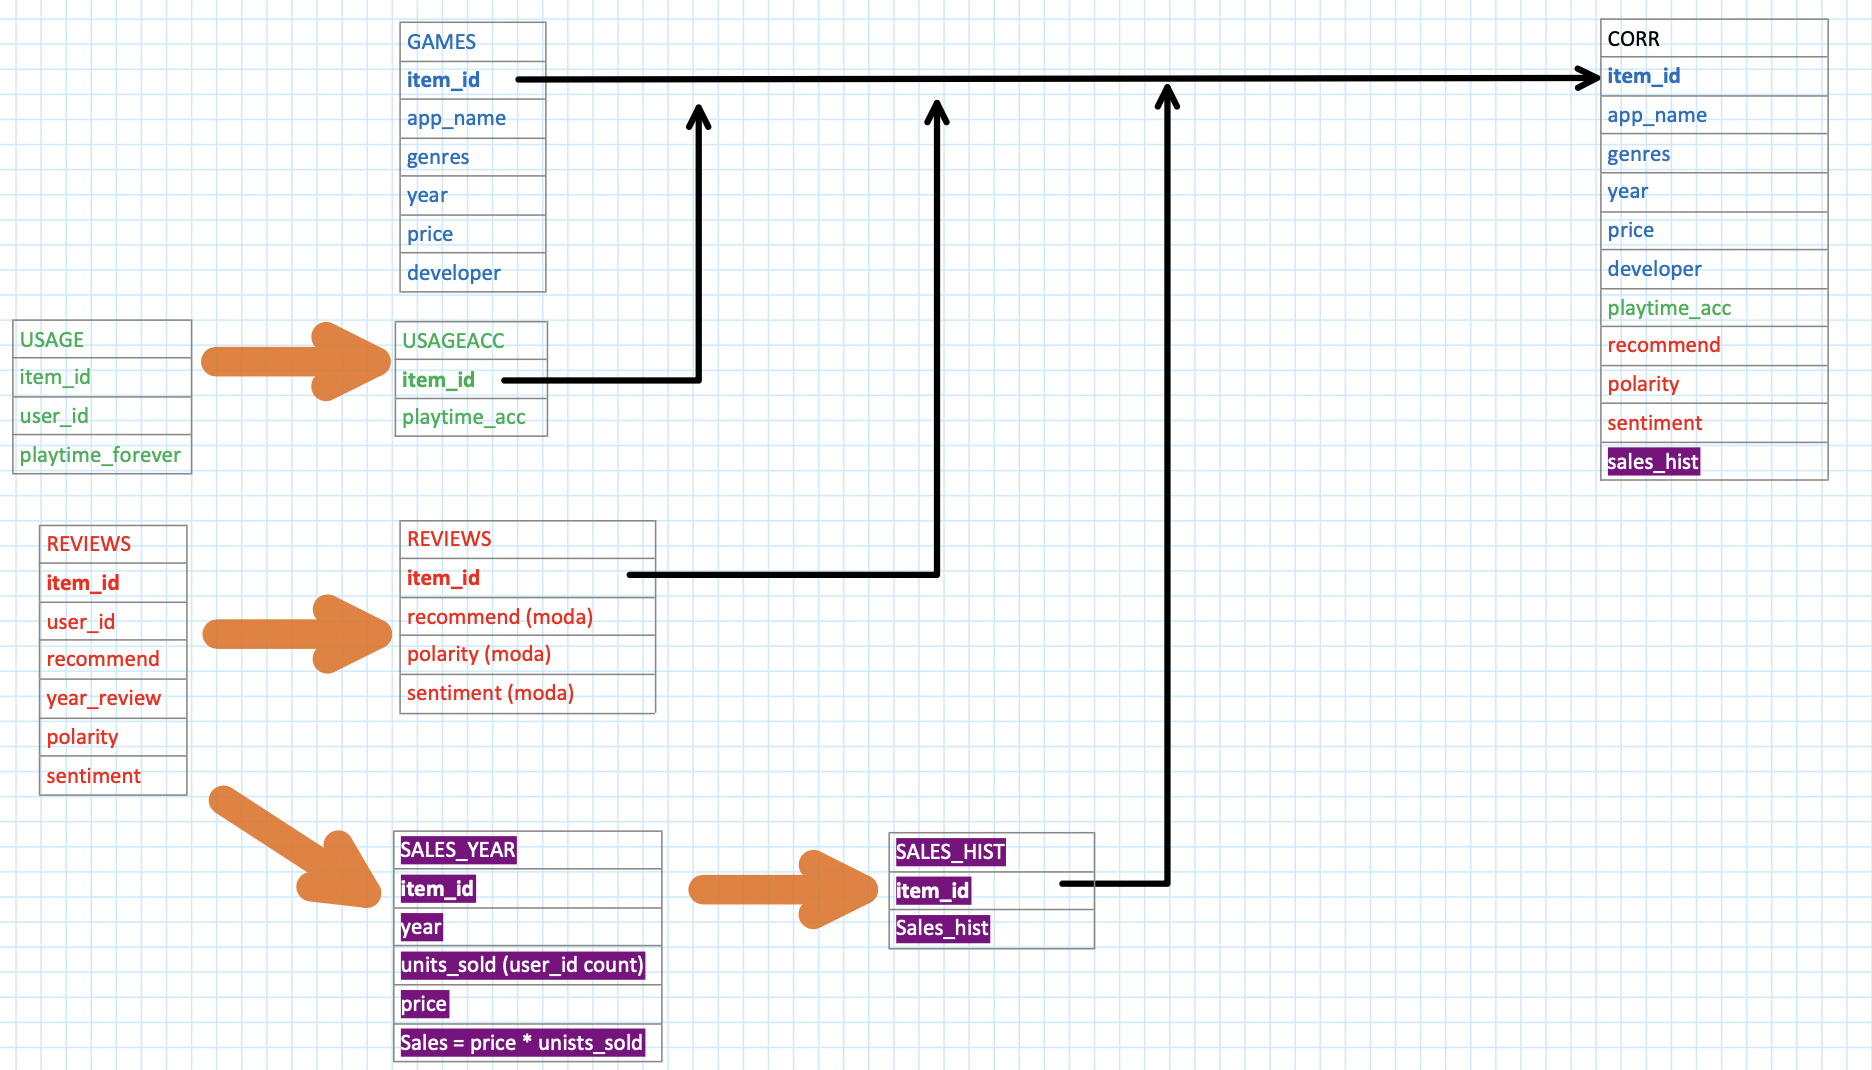

### Unión de dataframes

In [25]:
df_usageacc = df_usage.groupby('item_id')['playtime_forever'].sum().reset_index()
df_usageacc.columns = ['item_id', 'playtime_acc']

df_reviews_summary = pd.pivot_table(df_reviews, index='item_id', values=['polarity', 'recommend', 'sentiment'], aggfunc=lambda x: x.mode().iloc[0])

df_corr = pd.merge(df_games, df_usageacc, on='item_id', how='inner')
df_corr = pd.merge(df_corr, df_reviews_summary[['recommend', 'polarity', 'sentiment']], on='item_id', how='inner')
df_corr = pd.merge(df_corr, df_sales_hist[['item_id', 'sales_hist']], on='item_id', how='inner')

df_corr.to_csv('df_corre.csv', index=False)
df_corr.sample(2)


,item_id,app_name,genres,year,price,developer,playtime_acc,recommend,polarity,sentiment,sales_hist
466,283940,Freddi Fish and The Case of the Missing Kelp S...,Adventure,1994,6.99,Humongous Entertainment,9966.0,True,0.000000,1,6.99
1572,202130,Impire,Strategy,2013,19.99,Cyanide Montreal,79189.0,False,-0.433333,0,39.98


In [26]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       1958 non-null   int64  
 1   app_name      1958 non-null   object 
 2   genres        1958 non-null   object 
 3   year          1958 non-null   int64  
 4   price         1958 non-null   float64
 5   developer     1958 non-null   object 
 6   playtime_acc  1958 non-null   float64
 7   recommend     1958 non-null   bool   
 8   polarity      1958 non-null   float64
 9   sentiment     1958 non-null   int64  
 10  sales_hist    1958 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 155.0+ KB


### Limpieza de dataframe

In [27]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       1958 non-null   int64  
 1   app_name      1958 non-null   object 
 2   genres        1958 non-null   object 
 3   year          1958 non-null   int64  
 4   price         1958 non-null   float64
 5   developer     1958 non-null   object 
 6   playtime_acc  1958 non-null   float64
 7   recommend     1958 non-null   bool   
 8   polarity      1958 non-null   float64
 9   sentiment     1958 non-null   int64  
 10  sales_hist    1958 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 155.0+ KB


In [28]:
df_corr.duplicated().sum()

0

In [29]:
df_corr = df_corr.drop_duplicates()
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       1958 non-null   int64  
 1   app_name      1958 non-null   object 
 2   genres        1958 non-null   object 
 3   year          1958 non-null   int64  
 4   price         1958 non-null   float64
 5   developer     1958 non-null   object 
 6   playtime_acc  1958 non-null   float64
 7   recommend     1958 non-null   bool   
 8   polarity      1958 non-null   float64
 9   sentiment     1958 non-null   int64  
 10  sales_hist    1958 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 155.0+ KB


In [30]:
df_corr = df_corr.dropna(subset=['price'])
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       1958 non-null   int64  
 1   app_name      1958 non-null   object 
 2   genres        1958 non-null   object 
 3   year          1958 non-null   int64  
 4   price         1958 non-null   float64
 5   developer     1958 non-null   object 
 6   playtime_acc  1958 non-null   float64
 7   recommend     1958 non-null   bool   
 8   polarity      1958 non-null   float64
 9   sentiment     1958 non-null   int64  
 10  sales_hist    1958 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 155.0+ KB


## Análisis de distribuciones

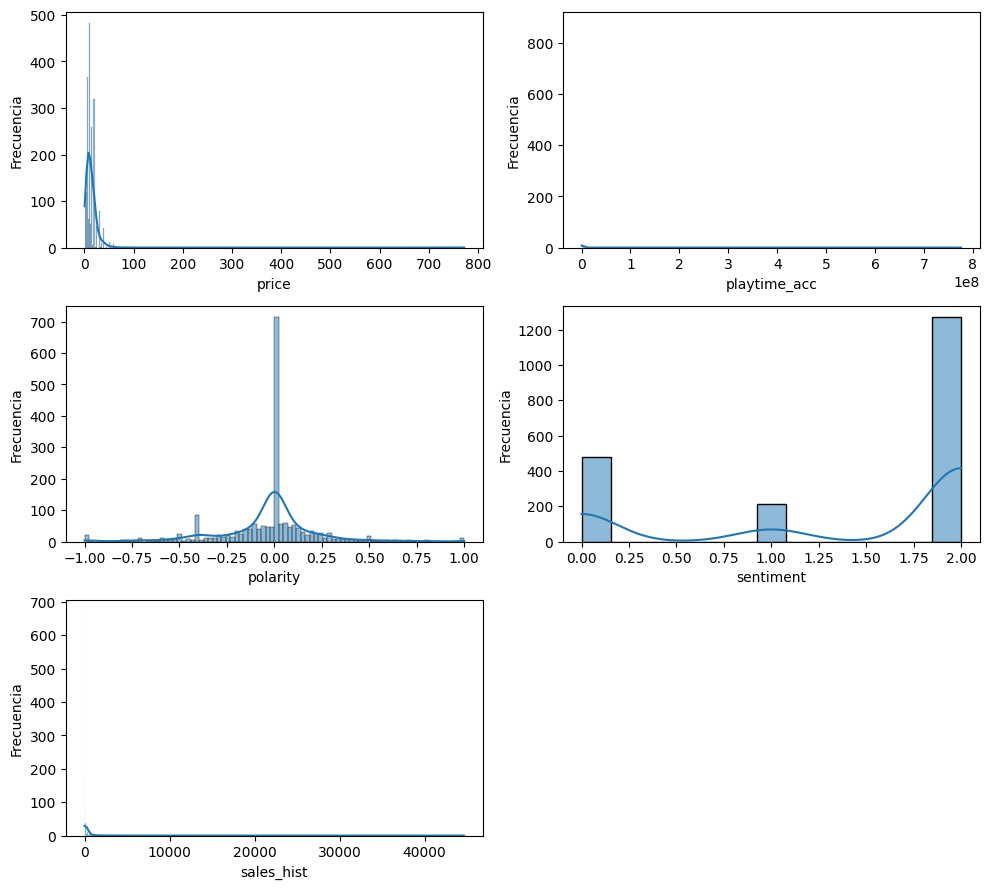

In [31]:
col_dist = ['price', 'playtime_acc', 'polarity', 'sentiment', 'sales_hist']
filas = (len(col_dist) + 1) // 2    # Configurar el tamaño de la figura y el número de subgráficos por fila
plt.figure(figsize=(10, 3 * filas))

# Iterar sobre las columnas seleccionadas y crear un histograma para cada una
for i, columna in enumerate(col_dist, 1):
    plt.subplot(filas, 2, i)
    sns.histplot(df_corr[columna], kde=True)
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## Correlaciones entre variables

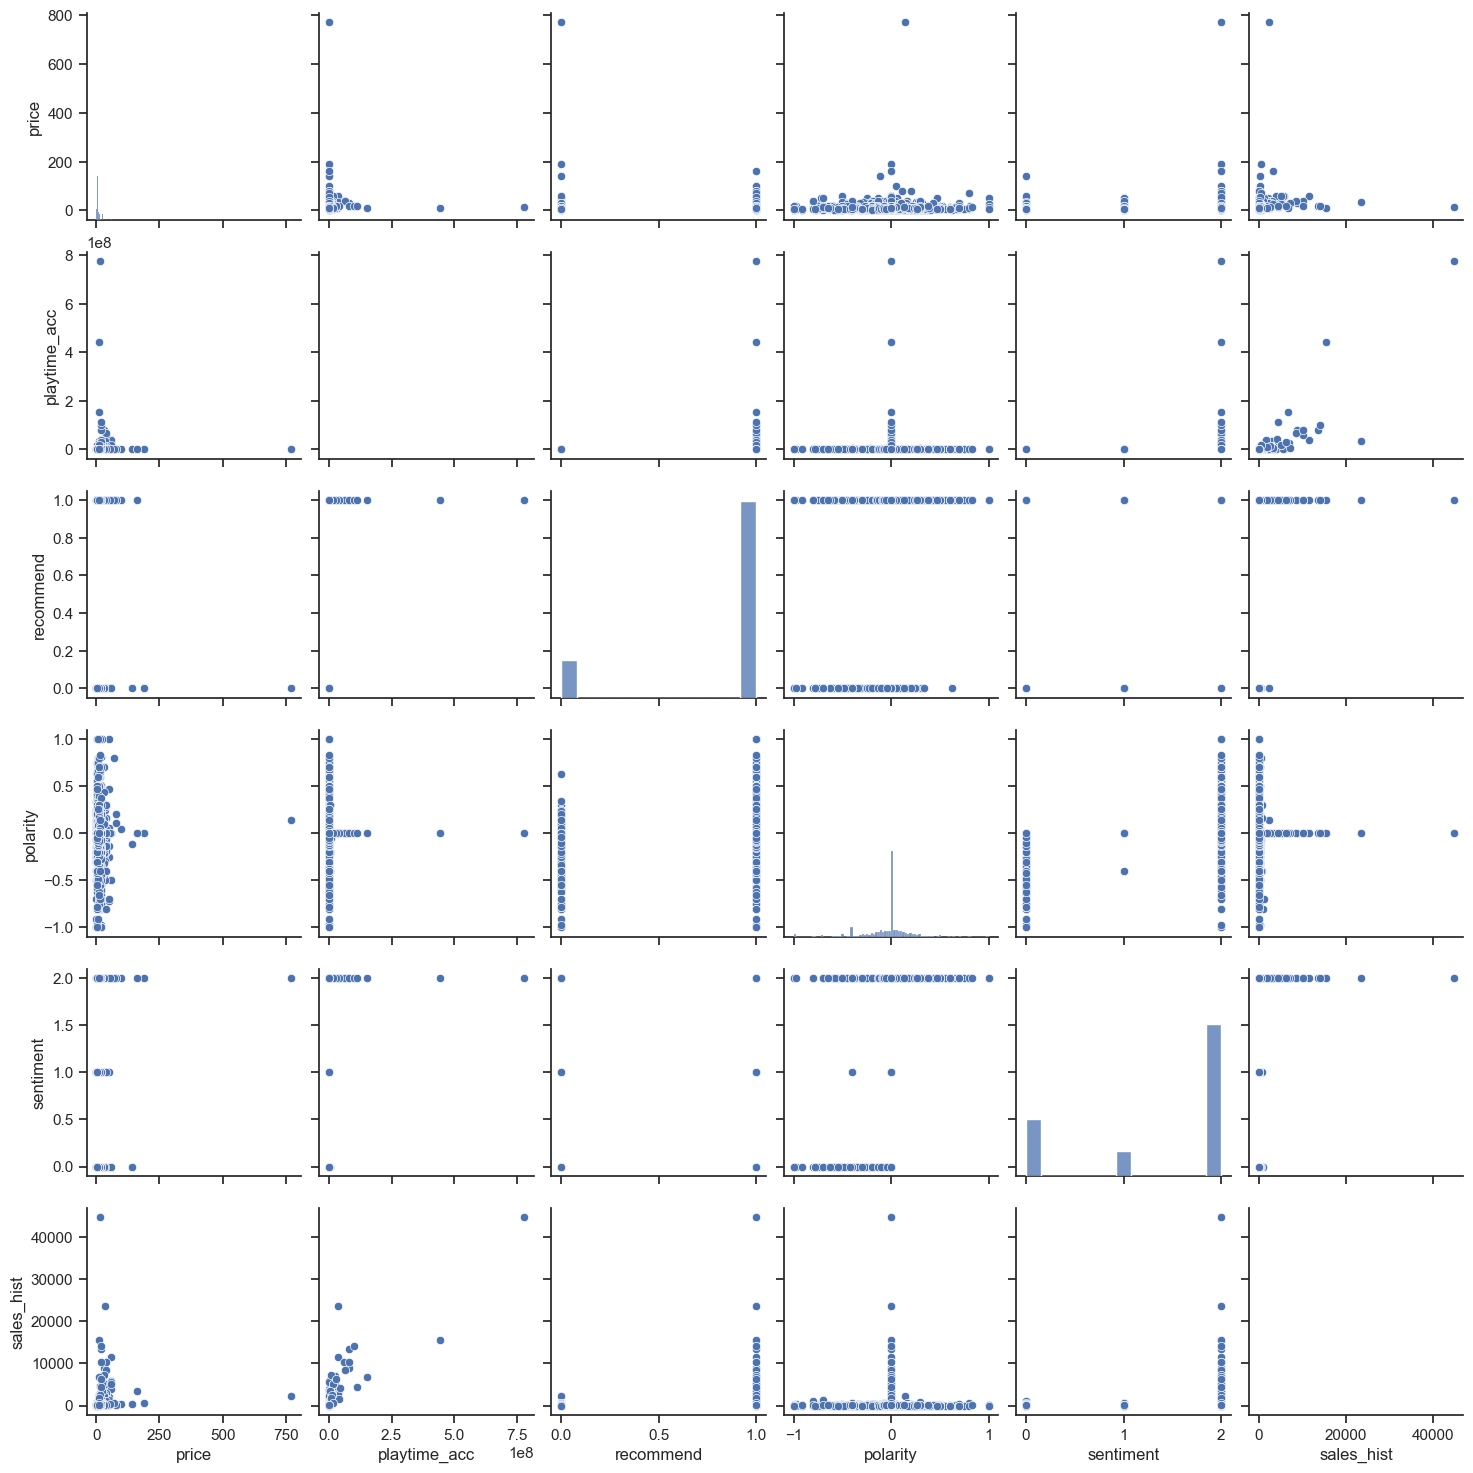

In [32]:
sns.set_theme(style="ticks")
sns.pairplot(df_corr[['price', 'playtime_acc', 'recommend', 'polarity', 'sentiment', 'sales_hist']])
plt.show()

In [33]:
corr_matrix = df_corr[['price', 'playtime_acc', 'recommend', 'polarity', 'sentiment', 'sales_hist']].corr()
corr_matrix

,price,playtime_acc,recommend,polarity,sentiment,sales_hist
price,1.000000,0.020965,-0.013494,0.013664,0.077939,0.135148
playtime_acc,0.020965,1.000000,0.035617,0.009285,0.055566,0.829056
recommend,-0.013494,0.035617,1.000000,0.240211,0.390904,0.069659
polarity,0.013664,0.009285,0.240211,1.000000,0.462346,0.014961
sentiment,0.077939,0.055566,0.390904,0.462346,1.000000,0.111400
sales_hist,0.135148,0.829056,0.069659,0.014961,0.111400,1.000000


Las correlaciones más significativas son las siguientes:

* sales_hist vs playtime_acc: 0.923542
* polarity vs sentiment: 0.705983

# Definición de dataframe para MLO

In [34]:
df_mlo = df_corr.copy()
df_mlo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       1958 non-null   int64  
 1   app_name      1958 non-null   object 
 2   genres        1958 non-null   object 
 3   year          1958 non-null   int64  
 4   price         1958 non-null   float64
 5   developer     1958 non-null   object 
 6   playtime_acc  1958 non-null   float64
 7   recommend     1958 non-null   bool   
 8   polarity      1958 non-null   float64
 9   sentiment     1958 non-null   int64  
 10  sales_hist    1958 non-null   float64
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 155.0+ KB


In [35]:
df_mlo

,item_id,app_name,genres,year,price,developer,playtime_acc,recommend,polarity,sentiment,sales_hist
0,70,Half-Life,Action,1998,9.99,Valve,2650946.0,True,0.000000,2,549.45
1,2400,The Ship: Murder Party,Action,2006,9.99,Outerlight Ltd.,1030947.0,True,0.000000,2,199.80
2,3800,Advent Rising,Action,2005,9.99,GlyphX Games,13384.0,True,-0.366667,0,9.99
3,1520,DEFCON,Indie,2006,9.99,Introversion Software,218144.0,True,0.000000,0,79.92
4,2420,The Ship: Single Player,Action,2006,9.99,Outerlight Ltd.,191701.0,True,0.075000,2,19.98
...,...,...,...,...,...,...,...,...,...,...,...
1953,40,Deathmatch Classic,Action,2001,4.99,Valve,154424.0,True,0.475000,2,4.99
1954,130,Half-Life: Blue Shift,Action,2001,4.99,Gearbox Software,436838.0,True,0.000000,2,14.97
1955,30,Day of Defeat,Action,2003,4.99,Valve,756375.0,True,-0.053333,2,19.96
1956,13230,Unreal Tournament 2004: Editor's Choice Edition,Action,2004,14.99,"Epic Games, Inc.",345093.0,True,-0.400000,2,74.95


In [36]:
# Conversión del campo "recommend"
df_mlo['recommend'] = df_mlo['recommend'].astype(int)

# Adición de un campo numérico para "genres"
genre_dict = {}     # Crear un diccionario para asignar un ID numérico a cada género
genre_id = 0

for genre in df_mlo['genres'].unique():
    genre_dict[genre] = genre_id
    genre_id += 1
df_mlo['genre_id'] = df_mlo['genres'].map(genre_dict)

df_mlo

,item_id,app_name,genres,year,price,developer,playtime_acc,recommend,polarity,sentiment,sales_hist,genre_id
0,70,Half-Life,Action,1998,9.99,Valve,2650946.0,1,0.000000,2,549.45,0
1,2400,The Ship: Murder Party,Action,2006,9.99,Outerlight Ltd.,1030947.0,1,0.000000,2,199.80,0
2,3800,Advent Rising,Action,2005,9.99,GlyphX Games,13384.0,1,-0.366667,0,9.99,0
3,1520,DEFCON,Indie,2006,9.99,Introversion Software,218144.0,1,0.000000,0,79.92,1
4,2420,The Ship: Single Player,Action,2006,9.99,Outerlight Ltd.,191701.0,1,0.075000,2,19.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1953,40,Deathmatch Classic,Action,2001,4.99,Valve,154424.0,1,0.475000,2,4.99,0
1954,130,Half-Life: Blue Shift,Action,2001,4.99,Gearbox Software,436838.0,1,0.000000,2,14.97,0
1955,30,Day of Defeat,Action,2003,4.99,Valve,756375.0,1,-0.053333,2,19.96,0
1956,13230,Unreal Tournament 2004: Editor's Choice Edition,Action,2004,14.99,"Epic Games, Inc.",345093.0,1,-0.400000,2,74.95,0


In [37]:
df_mlo = df_mlo[['item_id', 'app_name', 'genre_id', 'year', 'price', 'playtime_acc', 'recommend', 'polarity', 'sentiment']]
df_mlo

,item_id,app_name,genre_id,year,price,playtime_acc,recommend,polarity,sentiment
0,70,Half-Life,0,1998,9.99,2650946.0,1,0.000000,2
1,2400,The Ship: Murder Party,0,2006,9.99,1030947.0,1,0.000000,2
2,3800,Advent Rising,0,2005,9.99,13384.0,1,-0.366667,0
3,1520,DEFCON,1,2006,9.99,218144.0,1,0.000000,0
4,2420,The Ship: Single Player,0,2006,9.99,191701.0,1,0.075000,2
...,...,...,...,...,...,...,...,...,...
1953,40,Deathmatch Classic,0,2001,4.99,154424.0,1,0.475000,2
1954,130,Half-Life: Blue Shift,0,2001,4.99,436838.0,1,0.000000,2
1955,30,Day of Defeat,0,2003,4.99,756375.0,1,-0.053333,2
1956,13230,Unreal Tournament 2004: Editor's Choice Edition,0,2004,14.99,345093.0,1,-0.400000,2


In [38]:
# Exportación de dataset
df_mlo.to_csv("df_mlo.csv")